In [1]:
import numpy as np
import os
import sys
import tensorflow as tf

python_root = '../'
sys.path.insert(0, python_root)

from model.datagenerator import ImageDataGenerator

%matplotlib inline

# Restore model

Set `log_files_folder` to be the folder that contains the log files associated to the model that you want to restore and use to retrieve the embeddings.

In [2]:
log_files_folder = '/media/francesco/line_tools_data/logs/280119_0213/'

sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph(
    os.path.join(log_files_folder,
                 'triplet_loss_batch_all_ckpt/bgr-d_model_epoch90.ckpt.meta'))
saver.restore(
    sess,
    os.path.join(log_files_folder,
                 'triplet_loss_batch_all_ckpt/bgr-d_model_epoch90.ckpt'))


INFO:tensorflow:Restoring parameters from /media/francesco/line_tools_data/logs/280119_0213/triplet_loss_batch_all_ckpt/bgr-d_model_epoch90.ckpt


# Visualize the graph (probably not working, kept here for backcompatibility)
From http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [3]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [4]:
graph = tf.get_default_graph()
show_graph(graph)

# Visualize the kernels

In [5]:
conv1_kernels = sess.run('conv1/weights:0')
conv1_kernels_rgb = conv1_kernels[:,:,:3,:]
conv1_kernels_depth = conv1_kernels[:,:,-1,:]

visualization.py: Using values in config_paths_and_variables.sh for SCENENET_SCRIPTS_PATH, LINESANDIMAGESFOLDER_PATH.


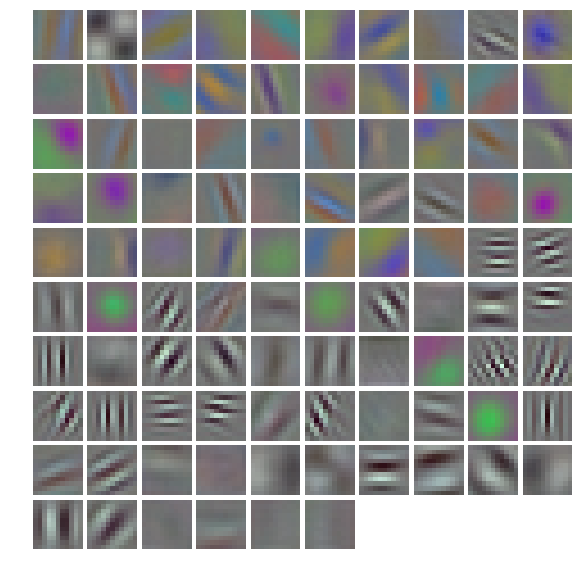

In [6]:
from tools.visualization import vis_square
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10) 

vis_square(conv1_kernels_rgb.transpose(3,0,1,2))

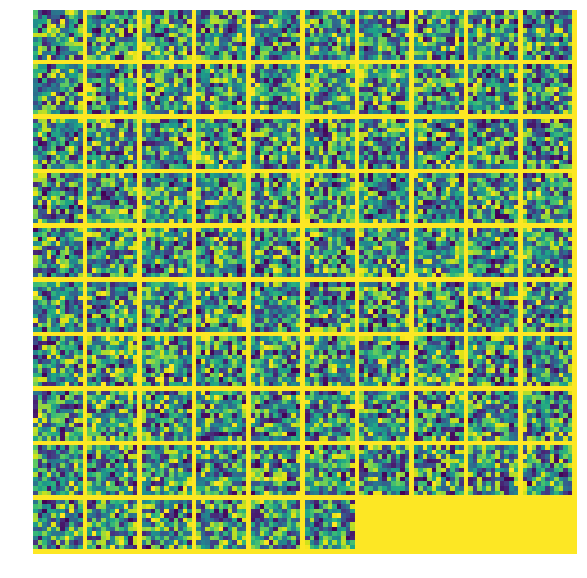

In [7]:
vis_square(conv1_kernels_depth.transpose(2,0,1))

# Retrieve embeddings for test set using trained model

**Configuration**

In [8]:
# Pickle files for test dataset (can be more than one).
test_files = ['/media/francesco/line_tools_data/pickle files/train_0/traj_1/pickled_test.pkl']

# If True, the ground-truth instance labels are read from the input dataset (in
# pickle-file format, each line has a 7-dimensional entry called 'labels' in the
# format [start point (3x)] [end point (3x)] [instance label]. The instance
# label is read as the last of these values). The ground-truth instance labels
# are later used to display-ground truth labels and to assign each embedding
# in the checkpoint for TensorBoard's Projector a label (that can be used, e.g.,
# to colour the points by instance label).
# NOTE: in principle, for a generic test dataset it might be the case that
# ground-truth instance labels are not available (e.g., when testing on a real
# set without ground-truth labelling), and it therefore makes sense to set
# use_ground_truth_instance_labels to False. In this case, it is still expected
# that the pickle files contain an entry called 'labels', with the first six
# entries corresponding to [start point (3x)] [end point (3x)].
use_ground_truth_instance_labels = True

# Batch size has no influence at test time, since the embeddings are retrieved
# from the already-trained model, the weights of which do not change anymore.
# The only difference that one has when varying the batch size is that
# embeddings for multiple lines are retrieved at the same time, but also that
# only a number of lines that is multiple of the batch size will have their
# embeddings retrieved. This is because the remaining lines would not be
# enough to form another batch. Selecting batch size equal to 1 ensures that
# embeddings are retrieved for all the lines in the test set.
batch_size = 128

**Restore model**

In [9]:
# Retrieve mean of the training set.
train_set_mean = sess.run('train_set_mean:0')

print("Train set mean is {}".format(train_set_mean))

# Set up data generator, that feeds the test dataset to the previously-trained network.
test_generator = ImageDataGenerator(
    test_files,
    image_type='bgr-d',
    mean=train_set_mean,
    read_as_pickle=True)

Train set mean is [ 25.02235112  22.31771021   6.16800402 723.14196181]
The dataset contains 1798 elements


In [10]:
# Input image tensor.
input_img = graph.get_tensor_by_name('input_img:0')
# Dropout probability tensor.
keep_prob = graph.get_tensor_by_name('keep_prob:0')
# Embeddings tensor.
embeddings = graph.get_tensor_by_name('l2_normalize:0')
# Line type tensor.
line_types = graph.get_tensor_by_name('line_types:0')
# Geometric info tensor.
try:
    geometric_info = graph.get_tensor_by_name('geometric_info:0')
except KeyError:
    geometric_info_found = False
else:
    geometric_info_found = True

if (use_ground_truth_instance_labels):
    # Tensor for ground-truth instance labels.
    labels = graph.get_tensor_by_name('labels:0')

In [11]:
from tools.lines_utils import get_label_with_line_center, get_geometric_info
from timeit import default_timer as timer

test_embeddings_all = np.empty(
        (0, int(embeddings.shape[1])), dtype=np.float32)
test_generator.reset_pointer()

test_set_size = len(test_generator.pickled_labels)
print("The test set contains {} lines.\n".format(test_set_size))

# Obtain embeddings for the lines in the test set.
for i in range(test_set_size / batch_size):
        print("Batch no. {}".format(i))
        (batch_input_img, batch_labels,
         batch_line_types) = test_generator.next_batch(batch_size)
        # Create dictionary of the values to feed to the tensors to run the
        # operation.
        feed_dict = {
            input_img: batch_input_img,
            line_types: batch_line_types,
            keep_prob: 1.
        }

        # To ensure backcompatibility, geometric information is fed into the
        # network only if the version of the network trained contains the
        # associated tensor.
        if geometric_info_found:
            # Retrieve geometric info depending on the type of line
            # parametrization used when training.
            batch_start_points = batch_labels[:, :3]
            batch_end_points = batch_labels[:, 3:6]
            if (geometric_info.shape[1] == 4):
                # Line parametrization: 'orthonormal'.
                batch_geometric_info = get_geometric_info(
                    start_points=batch_start_points,
                    end_points=batch_end_points,
                    line_parametrization='orthonormal')
                batch_geometric_info = np.array(batch_geometric_info).reshape(
                    -1, 4)
            elif (geometric_info.shape[1] == 6):
                # Line parametrization: 'direction_and_centerpoint'.
                batch_geometric_info = get_geometric_info(
                    start_points=batch_start_points,
                    end_points=batch_end_points,
                    line_parametrization='direction_and_centerpoint')
                batch_geometric_info = np.array(batch_geometric_info).reshape(
                    -1, 6)
            else:
                raise ValueError("The trained geometric_info Tensor should "
                                 "have shape[1] either equal to 4 (line "
                                 "parametrization 'orthonormal') or equal to 6 "
                                 "(line parametrization "
                                 "'direction_and_centerpoint').")
            feed_dict[geometric_info] = batch_geometric_info

        start_time = timer()
        output = sess.run(embeddings, feed_dict=feed_dict)
        end_time = timer()

        test_embeddings_all = np.vstack([test_embeddings_all, output])
        print('Time needed to retrieve descriptors for %d lines: %.3f seconds' %
              (batch_size, (end_time - start_time)))
        # Display every 5 steps.
        if i % 5 == 0:
            print("Embeddings got for {} lines ".format(
                test_embeddings_all.shape[0]))
            
            
num_lines_with_embeddings = len(test_embeddings_all)

print("\nThe total number of lines for which embeddings were retrieved is "
      "{}.".format(num_lines_with_embeddings))

The test set contains 1798 lines.

Batch no. 0
Time needed to retrieve descriptors for 128 lines: 9.288 seconds
Embeddings got for 128 lines 
Batch no. 1
Time needed to retrieve descriptors for 128 lines: 0.417 seconds
Batch no. 2
Time needed to retrieve descriptors for 128 lines: 0.446 seconds
Batch no. 3
Time needed to retrieve descriptors for 128 lines: 0.432 seconds
Batch no. 4
Time needed to retrieve descriptors for 128 lines: 0.441 seconds
Batch no. 5
Time needed to retrieve descriptors for 128 lines: 0.394 seconds
Embeddings got for 768 lines 
Batch no. 6
Time needed to retrieve descriptors for 128 lines: 0.400 seconds
Batch no. 7
Time needed to retrieve descriptors for 128 lines: 0.442 seconds
Batch no. 8
Time needed to retrieve descriptors for 128 lines: 0.442 seconds
Batch no. 9
Time needed to retrieve descriptors for 128 lines: 0.411 seconds
Batch no. 10
Time needed to retrieve descriptors for 128 lines: 0.394 seconds
Embeddings got for 1408 lines 
Batch no. 11
Time needed t

# Cluster the obtained embeddings
It is currently possible to use three different types of clustering:
- K-means
- Agglomerative Clustering
- Affinity Propagation

The first two require to specify the number of cluster to form, whereas the last one automatically selects a number of clusters.

**Configuration**

In [12]:
from tools.cluster_lines import cluster_lines_affinity_propagation, \
                                cluster_lines_kmeans, \
                                cluster_lines_aggr_clustering


# Cluster strategy. One of "kmeans", "aggr_clustering" and
# "affinity_propagation".
cluster_strategy = "aggr_clustering"

# Visualizer of the lines coloured with the instances from clustering. Possible
# values: 'open3d', 'matplotlib'.
visualizer = 'open3d'

**Retrieve ground-truth instance labels if specified**

In [13]:
data_lines_world = np.array(test_generator.pickled_labels, dtype=np.float32)

# Only keep the lines for which an embedding was sought (since data is processed
# in batches only for a number of lines multiple of the batch size the embedding
# is computed, cf. above).
data_lines_world = data_lines_world[:num_lines_with_embeddings]
if (use_ground_truth_instance_labels):
    if (data_lines_world.shape[1] != 7):
        raise ValueError("Ground-truth instance labels not found: entry 'labels' "
                         "of the lines in the pickle file has not dimension 7. "
                         "Please set 'use_ground_truth_instance_labels' to False.")
    else:
        instance_labels = data_lines_world[:, -1]

**Cluster lines**

The number of clusters when using `kmeans` or `aggr_clustering` can be changed by properly setting `num_clusters`.

In [14]:
if cluster_strategy == "kmeans":
    num_clusters = 32
    print("Clustering using K-means with {} clusters".format(num_clusters))
    cluster_labels = cluster_lines_kmeans(
        embeddings=test_embeddings_all, num_clusters=num_clusters)
elif cluster_strategy == "aggr_clustering":
    num_clusters = 9
    print("Clustering using Agglomerative Clustering with {} clusters".format(
        num_clusters))
    cluster_labels = cluster_lines_aggr_clustering(
        embeddings=test_embeddings_all, num_clusters=num_clusters)
elif cluster_strategy == "affinity_propagation":
    print("Clustering using Affinity Propagation")
    cluster_labels, num_clusters = cluster_lines_affinity_propagation(
        embeddings=test_embeddings_all)
    print("Found {} clusters.".format(num_clusters))
else:
    raise ValueError("Invalid clustering strategy. Please use one of: "
                     "'kmeans', 'aggr_clustering', "
                     "'affinity_propagation'.")

Clustering using Agglomerative Clustering with 9 clusters


**Display lines with colours**

In [15]:
from tools.visualization import pcl_lines_for_plot

# Map real instances and instances from clustering and display lines with
# colours. Lines with the same colour belong to the same cluster.
if visualizer == 'open3d':
    from tools.visualization import plot_lines_with_open3d
    pcl_lines_open3d_cluster = pcl_lines_for_plot(
        data_lines_world, lines_color=cluster_labels, visualizer='open3d')
    print("Displaying scene with obtained instances")
    plot_lines_with_open3d(pcl_lines_open3d_cluster, "Clusterized instances")
    if (use_ground_truth_instance_labels):
        pcl_lines_open3d_ground_truth = pcl_lines_for_plot(
            data_lines_world,
            lines_color=np.int32(instance_labels),
            visualizer='open3d')
        print("Displaying scene with ground-truth instances")
        plot_lines_with_open3d(pcl_lines_open3d_ground_truth,
                               "Ground-truth instances")

elif visualizer == 'matplotlib':
    from tools.visualization import plot_lines_with_matplotlib
    pcl_lines_matplotlib_cluster = pcl_lines_for_plot(
        data_lines_world, lines_color=cluster_labels, visualizer='matplotlib')
    print("Displaying scene with obtained instances")
    plot_lines_with_matplotlib(pcl_lines_matplotlib_cluster,
                               "Clusterized instances")
    if (use_ground_truth_instance_labels):
        pcl_lines_matplotlib_ground_truth = pcl_lines_for_plot(
            data_lines_world,
            lines_color=np.int32(instance_labels),
            visualizer='matplotlib')
        print("Displaying scene with ground-truth instances")
        plot_lines_with_matplotlib(pcl_lines_matplotlib_ground_truth,
                                   "Ground-truth instances")

Displaying scene with obtained instances
Displaying scene with ground-truth instances


# Visualize the embeddings in the feature space, coloured by instance label

In [16]:
from tensorflow.contrib import tensorboard

LOG_DIR = os.path.join(log_files_folder, 'embedding_logs')
if not os.path.isdir(LOG_DIR): os.makedirs(LOG_DIR)
metadata = os.path.join(LOG_DIR, 'embedding_metadata.tsv')
test_embeddings = tf.Variable(test_embeddings_all, name='test_embeddings')

with open(metadata, 'w') as metadata_file:
    if (use_ground_truth_instance_labels):
        for label in instance_labels:
            metadata_file.write('%d\n' % label)
    else:
        print("Flag 'use_ground_truth_instance_labels' is set to False, "
              "saving the embeddings all with the same label (0). Colouring "
              "in TensorBoard's Projector will therefore not be possible.")
        for _ in range(data_lines_world.shape[0]):
            metadata_file.write('0\n')

with tf.Session() as sess:
    saver = tf.train.Saver([test_embeddings])

    sess.run(test_embeddings.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'test_embeddings.ckpt'))

    config = tensorboard.plugins.projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = test_embeddings.name
    # Link this tensor to its metadata file (i.e., labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    tensorboard.plugins.projector.visualize_embeddings(
        tf.summary.FileWriter(LOG_DIR), config)


In [ ]:
!tensorboard --logdir ../logs/tmp/embedding_logs --port=6007

TensorBoard 1.12.0 at http://francesco:6007 (Press CTRL+C to quit)
